# Images

## Step 1: Extract the Dataset

In [ ]:
import zipfile
import os

# Path to the uploaded zip file and extraction target directory
zip_path = '/content/cats_and_dogs_filtered.zip'
extraction_path = '/content/cats_and_dogs_filtered'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Check the contents of the extracted directory
os.listdir(extraction_path)

['cats_and_dogs_filtered']

## Step 2: Prepare the Training and Validation Datasets

In [ ]:
import tensorflow as tf

# Define constants
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
dataset_path = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered'

# Set up training and validation directories
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

# Create training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Step 3: Set Up the Transfer Learning Model


In [ ]:
# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Create a new model on top of the output of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
63/63 [==============================] - 49s 707ms/step - loss: 0.6946 - accuracy: 0.5580 - val_loss: 0.6612 - val_accuracy: 0.6080
Epoch 2/10
63/63 [==============================] - 32s 508ms/step - loss: 0.6321 - accuracy: 0.6440 - val_loss: 0.6491 - val_accuracy: 0.6270
Epoch 3/10
63/63 [==============================] - 44s 701ms/step - loss: 0.6131 - accuracy: 0.6600 - val_loss: 0.6447 - val_accuracy: 0.6330
Epoch 4/10
63/63 [==============================] - 42s 672ms/step - loss: 0.5983 - accuracy: 0.6715 - val_loss: 0.6360 - val_accuracy: 0.6400
Epoch 5/10
63/63 [==============================] - 41s 660ms/step - loss: 0.5895 - accuracy: 0.6870 - val_loss: 0.6341 - val_accuracy: 0.6420
Epoch 6/10
63/63 [==============================] - 45s 716ms/step - loss: 0.5781 - accuracy: 0.6950 - val_loss: 0.6308 - val_accuracy: 0.6500
Epoch 7/10
63/63 [==============================] - 41s 647ms/step - loss: 0.57

## Step 4: Fine-Tuning

In [ ]:
# Unfreeze the base_model and set the bottom layers to be untrainable
base_model.trainable = True

# Freeze all layers except for the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model (necessary for these changes to take effect) with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Continue training
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs  # previous + fine-tune epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 44s 633ms/step - loss: 1.1232 - accuracy: 0.5590 - val_loss: 0.8164 - val_accuracy: 0.5670
Epoch 11/20
63/63 [==============================] - 48s 772ms/step - loss: 0.8630 - accuracy: 0.6130 - val_loss: 0.9722 - val_accuracy: 0.5260
Epoch 12/20
63/63 [==============================] - 41s 649ms/step - loss: 0.7145 - accuracy: 0.6520 - val_loss: 1.0346 - val_accuracy: 0.5160
Epoch 13/20
63/63 [==============================] - 49s 787ms/step - loss: 0.6211 - accuracy: 0.6900 - val_loss: 1.0293 - val_accuracy: 0.5180
Epoch 14/20
63/63 [==============================] - 49s 791ms/step - loss: 0.5614 - accuracy: 0.7105 - val_loss: 0.9988 - val_accuracy: 0.5220
Epoch 15/20
63/63 [==============================] - 49s 779ms/step - loss: 0.5213 - accuracy: 0.7360 - val_loss: 0.9473 - val_accuracy: 0.5310
Epoch 16/20
63/63 [==============================] - 50s 795ms/step - loss: 0.4914 - accuracy: 0.7570 - val_loss: 0.9059 - val_accuracy:

## Step 5: Plot Training & Validation Accuracy and Loss Values


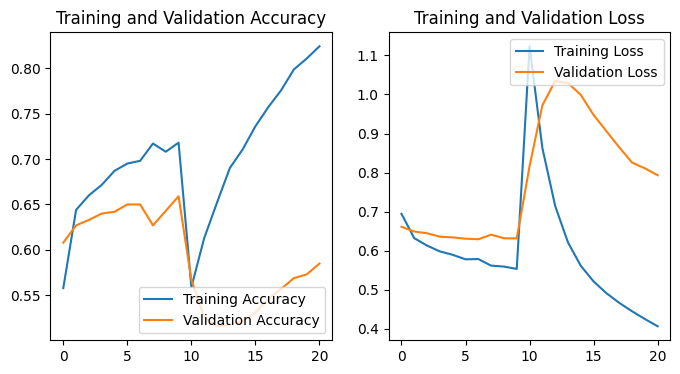

In [ ]:
import matplotlib.pyplot as plt

# Combine the history of the initial training and fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Make sure epochs range is set to the total number of epochs
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Video

## Step 1: Create a Simulated Video Dataset

In [ ]:
import numpy as np
import tensorflow as tf

# Constants
NUM_CLASSES = 10
NUM_VIDEOS = 50
FRAMES_PER_VIDEO = 20
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
CHANNELS = 3

# Generate random data to simulate video frames
def generate_video_data(num_videos, frames_per_video, height, width, channels):
    return np.random.randint(0, 256, size=(num_videos, frames_per_video, height, width, channels), dtype=np.uint8)

# Labels for each video
def generate_video_labels(num_videos, num_classes):
    return np.random.randint(0, num_classes, size=(num_videos,))

# Generate training and testing data
X_train = generate_video_data(NUM_VIDEOS, FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, CHANNELS)
y_train = generate_video_labels(NUM_VIDEOS, NUM_CLASSES)
X_test = generate_video_data(int(NUM_VIDEOS * 0.2), FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, CHANNELS)
y_test = generate_video_labels(int(NUM_VIDEOS * 0.2), NUM_CLASSES)

# Convert to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Step 2: Preprocess and Prepare Dataset

In [ ]:
def preprocess_video(video, label):
    video = tf.cast(video, tf.float32) / 255.0  # Normalize the video frames
    return video, label

BATCH_SIZE = 5

train_data = train_data.map(preprocess_video).batch(BATCH_SIZE)
test_data = test_data.map(preprocess_video).batch(BATCH_SIZE)

## Step 3: Model Building and Transfer Learning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

# Model architecture
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, CHANNELS)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Step 4: Train the Model


In [ ]:
model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
10/10 [==============================] - 228s 22s/step - loss: 543.8677 - accuracy: 0.1600 - val_loss: 166.9413 - val_accuracy: 0.1000
Epoch 2/10
10/10 [==============================] - 221s 22s/step - loss: 31.6427 - accuracy: 0.1600 - val_loss: 2.8334 - val_accuracy: 0.1000
Epoch 3/10
10/10 [==============================] - 223s 22s/step - loss: 1.7441 - accuracy: 0.6200 - val_loss: 2.7911 - val_accuracy: 0.1000
Epoch 4/10
10/10 [==============================] - 220s 22s/step - loss: 0.4689 - accuracy: 0.9000 - val_loss: 4.1060 - val_accuracy: 0.1000
Epoch 5/10
10/10 [==============================] - 223s 22s/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 4.5759 - val_accuracy: 0.1000
Epoch 6/10
10/10 [==============================] - 222s 22s/step - loss: 2.3967e-04 - accuracy: 1.0000 - val_loss: 13.6981 - val_accuracy: 0.1000
Epoch 7/10
10/10 [==============================] - 224s 22s/step - loss: 0.1560 - accuracy: 0.9800 - val_loss: 3.6370 - val_accuracy: 0.1

In [ ]:
# Unfreeze all layers in the model
for layer in model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for fine-tuning
history_finetune = model.fit(train_data, validation_data=test_data, epochs=5, batch_size=32)  # Adjust the batch size as needed

Epoch 1/5
10/10 [==============================] - 231s 23s/step - loss: 6.5065 - accuracy: 0.1200 - val_loss: 6.9449 - val_accuracy: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 219s 22s/step - loss: 3.5349 - accuracy: 0.1600 - val_loss: 2.8513 - val_accuracy: 0.2000
Epoch 3/5
10/10 [==============================] - 221s 22s/step - loss: 2.4235 - accuracy: 0.1400 - val_loss: 2.9349 - val_accuracy: 0.1000
Epoch 4/5
10/10 [==============================] - 231s 23s/step - loss: 2.2885 - accuracy: 0.1200 - val_loss: 3.1189 - val_accuracy: 0.1000
Epoch 5/5
10/10 [==============================] - 221s 22s/step - loss: 2.0362 - accuracy: 0.2800 - val_loss: 2.6913 - val_accuracy: 0.0000e+00


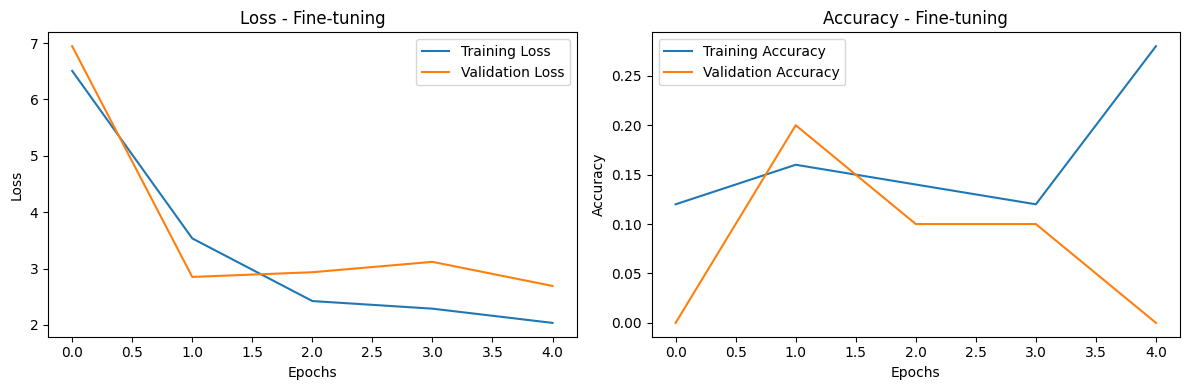

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title=''):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the training and validation loss and accuracy
plot_history(history_finetune, 'Fine-tuning')

# Audio

In [ ]:
import zipfile
import os

# Path to the zip file and extraction directory
zip_path = '/content/DvC.zip'
extract_dir = '/content/audio_dataset'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List contents of the extracted directory
os.listdir(extract_dir)

['DvC']

In [ ]:
# List contents of the DvC directory
os.listdir(os.path.join(extract_dir, 'DvC'))

['Cats', 'Dogs']

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os

# Load YAMNet from TensorFlow Hub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def load_wav_for_map(filename, label):
    '''Function to load and preprocess audio files for YAMNet'''
    file_path = tf.io.read_file(filename)
    wav_data, sample_rate = tf.audio.decode_wav(file_path, desired_channels=1)
    wav_data = tf.squeeze(wav_data, axis=-1)
    return wav_data, label

def extract_embedding(wav_data, label):
    '''Extract embeddings from the waveform using YAMNet'''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings, tf.fill([num_embeddings], label)

# Filter out non-WAV files and prepare the dataset
def is_wav_file(filename):
    return filename.lower().endswith('.wav')

categories = ['Cats', 'Dogs']
files, labels = [], []

for category in categories:
    category_dir = os.path.join(extract_dir, 'DvC', category)
    for filename in os.listdir(category_dir):
        if is_wav_file(filename):
            files.append(os.path.join(category_dir, filename))
            labels.append(category)

file_ds = tf.data.Dataset.from_tensor_slices((files, labels))
file_ds = file_ds.map(load_wav_for_map)

embeddings_ds = file_ds.map(extract_embedding).unbatch()

# Collect embeddings and labels for training
embeddings, targets = [], []
for emb, lab in embeddings_ds:
    embeddings.append(emb.numpy())
    targets.append(lab.numpy())

# Convert lists to NumPy arrays for training
embeddings = np.vstack(embeddings)
targets = np.hstack(targets)

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", targets.shape)

Embeddings shape: (4767, 1024)
Labels shape: (4767,)


In [ ]:
import tensorflow as tf

# Shuffle and batch the dataset
dataset = tf.data.Dataset.from_tensor_slices((embeddings, targets))
dataset = dataset.shuffle(len(targets)).batch(32)

# Calculate the number of batches in the full dataset
total_batches = len(targets) // 32 + (len(targets) % 32 != 0)

# Split the data into train and validation
train_size = int(0.8 * total_batches)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Print sizes of the datasets to verify
print("Total batches:", total_batches)
print("Training batches:", train_size)
print("Validation batches:", total_batches - train_size)

# Ensure datasets are not empty
assert not train_dataset.cardinality().numpy() == 0, "Training dataset is empty"
assert not val_dataset.cardinality().numpy() == 0, "Validation dataset is empty"

# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1024,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Total batches: 149
Training batches: 119
Validation batches: 30
Epoch 1/10
119/119 [==============================] - 3s 12ms/step - loss: 0.2646 - accuracy: 0.9070 - val_loss: 0.1416 - val_accuracy: 0.9458
Epoch 2/10
119/119 [==============================] - 1s 10ms/step - loss: 0.1602 - accuracy: 0.9477 - val_loss: 0.1199 - val_accuracy: 0.9614
Epoch 3/10
119/119 [==============================] - 1s 10ms/step - loss: 0.1195 - accuracy: 0.9554 - val_loss: 0.0775 - val_accuracy: 0.9698
Epoch 4/10
119/119 [==============================] - 1s 10ms/step - loss: 0.1134 - accuracy: 0.9661 - val_loss: 0.0536 - val_accuracy: 0.9844
Epoch 5/10
119/119 [==============================] - 1s 10ms/step - loss: 0.1156 - accuracy: 0.9664 - val_loss: 0.1068 - val_accuracy: 0.9656
Epoch 6/10
119/119 [==============================] - 1s 11ms/step - loss: 0.0912 - accuracy: 0.9722 - val_loss: 0.0886 - val_accuracy: 0.9739
Epoch 7/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0

In [ ]:
# Save the model
model.save('/content/your_model')

# Load the model
reloaded_model = tf.keras.models.load_model('/content/your_model')

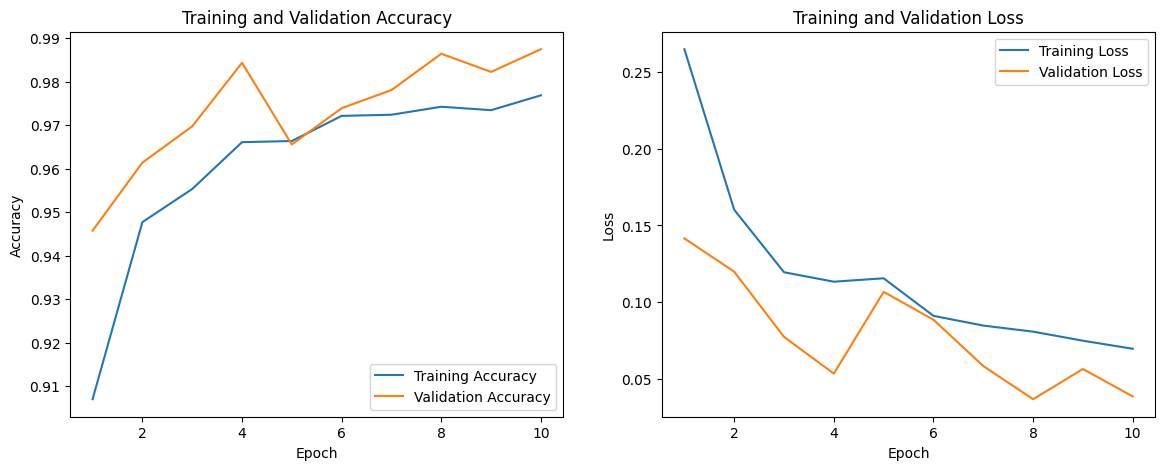

In [ ]:
import matplotlib.pyplot as plt

# Retrieve history data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()